#About This Project
### In this project, your task is to build and train a model to recognize opinions expressed in a sentence. This is an LSTM multi-class (positive, negative, neutral) classification problem.

##Sentiment Analysis
what is Sentiment Analysis?
the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.


#SentiPers Corpus

https://arxiv.org/ftp/arxiv/papers/1801/1801.07737.pdf

SentiPers is a sentiment corpus for Persian. This corpus contains more than 26,000 sentences of users’ opinions from digital product domain.  The data used in construction of SentiPers is extracted from a website named Digikala.

This is an open-source corpus by University of Guilan.

https://github.com/Text-Mining/Persian-Sentiment-Resources/blob/master/SentiPersV1.0.rar

https://www.peykaregan.ir/dataset/%D9%BE%DB%8C%DA%A9%D8%B1%D9%87-%D9%81%D8%A7%D8%B1%D8%B3%DB%8C-%D8%AA%D8%AD%D9%84%DB%8C%D9%84-%D8%A7%D8%AD%D8%B3%D8%A7%D8%B3-%D8%B3%D9%86%D8%AA%DB%8C%E2%80%8C%D9%BE%D8%B1%D8%B3


###We use a part of this corpus that contains about 9,000 sentences with 3 labels: positive, negative and neutral.




#Implementation

## Importing libraries

In [143]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, Bidirectional, GlobalMaxPool1D, Dropout, Activation, GRU, SimpleRNN
from keras.layers import Conv1D

from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import gc
import matplotlib.pyplot as plt
%matplotlib inline

# New Section

##Mounting your Google Drive files in Google Colab

In [44]:
from google.colab import drive
drive.mount('/MyDrive') 

Mounted at /MyDrive


### Read  train data file

In [60]:
data = pd.read_csv('/MyDrive/MyDrive/SentimentProj/sentipers_sentiment.csv')

data = data[['text','sentiment']]

In [61]:
print('Positive:',data[ data['sentiment'] == 'Positive'].size)
print('Negative:',data[ data['sentiment'] == 'Negative'].size)
print('Neutral:',data[ data['sentiment'] == 'Neutral'].size)


Positive: 8882
Negative: 1902
Neutral: 6870


###Tokenization - We need to break down the sentence into unique words. For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]

###Indexing - We put the words in a dictionary-like structure and give them an index each For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}

###Index Representation- We could represent the sequence of words in the texts in the form of index

In [94]:
max_fatures = 70000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
y = np.array(pd.get_dummies(data['sentiment']))

## How do you know what is the best "maxlen" to set?
One of the ways to go about it is to see the distribution of the number of words in sentences.

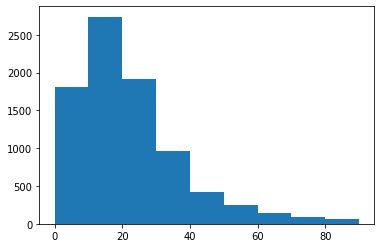

In [95]:
totalNumWords = [len(one_comment) for one_comment in X]
plt.hist(totalNumWords,bins = np.arange(0,100,10))
plt.show()

In [102]:
maxlen = 80
X = pad_sequences(X, maxlen)
# https://drive.google.com/file/d/1-9dP3crGeqT9C0GrDfjBlCZDtlioSx3B/view?usp=sharing

##  load our embeddings model into a dictionary 

In [109]:

def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
    if(typeToLoad=="glove"):
        EMBEDDING_FILE='/MyDrive/MyDrive/SentimentProj/vectors.txt'
        embed_size = 300
    
    if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
        embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
        with open(EMBEDDING_FILE,'r', encoding='utf8')as f:
            for line in f:
                try:
                    values = line.split()

                    if len(values)==301:
                        word = values[0]    
                        coefs = np.asarray(values[1:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==302:
          #print(len(value))
                        word = values[0]+'\u200c'+values[1]   
                        coefs = np.asarray(values[2:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==303:
                        word = values[0]+'\u200c'+values[1]+'\u200c'+values[2]  
                        coefs = np.asarray(values[3:], dtype='float32')
                        embeddings_index[word] = coefs
                except Exception as inst:
                        print(inst)

            
    gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
    nb_words = len(tokenizer.word_index) + 1
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
    embeddedCount = 0
    embedding_matrix[0] = 0
    for word, i in tokenizer.word_index.items():
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
    print('total embedded:',embeddedCount,'common words')
        
    del(embeddings_index)
    gc.collect()
        
        #finally, return the embedding matrix
    return embedding_matrix

#training steps

##Design your Architecture for Sentiment Analysis task. You can use embedding, LSTM, GRU and CNN layers in your architecture.


##building  your models

**LSTM1:** Glove-60-maxpool-dp-Dense(50)-dp-dense

In [110]:
embedding_matrix = loadEmbeddingMatrix('glove')

inp = Input(shape=(maxlen, ))
x = Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix], mask_zero=True,trainable=False)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

print(model.summary())

total embedded: 5554 common words
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 80)]              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 80, 300)           3825600   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 80, 120)           173280    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 120)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                6050      
_________________________________________________________________
dropout_13 (Dropout)     

##Fit your models

In [111]:
print(np.size(X),np.size(y))

706160 26481


In [112]:
batch_size = 64
epochs = 20
hist = model.fit(X,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/20
111/111 [==============================] - 74s 632ms/step - loss: 0.5954 - accuracy: 0.4853 - val_loss: 0.5192 - val_accuracy: 0.6291
Epoch 2/20
111/111 [==============================] - 69s 625ms/step - loss: 0.5113 - accuracy: 0.6266 - val_loss: 0.4853 - val_accuracy: 0.6489
Epoch 3/20
111/111 [==============================] - 70s 629ms/step - loss: 0.4639 - accuracy: 0.6663 - val_loss: 0.4795 - val_accuracy: 0.6484
Epoch 4/20
111/111 [==============================] - 70s 627ms/step - loss: 0.4167 - accuracy: 0.7092 - val_loss: 0.4739 - val_accuracy: 0.6438
Epoch 5/20
111/111 [==============================] - 70s 629ms/step - loss: 0.3845 - accuracy: 0.7302 - val_loss: 0.4682 - val_accuracy: 0.6648
Epoch 6/20
111/111 [==============================] - 70s 630ms/step - loss: 0.3497 - accuracy: 0.7602 - val_loss: 0.4661 - val_accuracy: 0.6580
Epoch 7/20
111/111 [==============================] - 70s 631ms/step - loss: 0.3373 - accuracy: 0.7759 - val_loss: 0.4714 - val_ac

In [113]:
h1 = hist

**LSTM2**: Glove-LSTM(60)-dp(0.3)-LSTM(32)-maxpool-dp(0.4)-Dense(50)-dp-dense

In [116]:
embedding_matrix = loadEmbeddingMatrix('glove')

inp = Input(shape=(maxlen, ))
x = Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix], mask_zero=True,trainable=False)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(32, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.4)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

print(model.summary())

total embedded: 5554 common words
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 80)]              0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 80, 300)           3825600   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 80, 120)           173280    
_________________________________________________________________
dropout_17 (Dropout)         (None, 80, 120)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 80, 64)            39168     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 64)                0         
_________________________________________________________________
dropout_18 (Dropout)     

In [118]:
batch_size = 64
epochs = 10
hist = model.fit(X,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
111/111 [==============================] - 139s 1s/step - loss: 0.4821 - accuracy: 0.6508 - val_loss: 0.4858 - val_accuracy: 0.6467
Epoch 2/10
111/111 [==============================] - 139s 1s/step - loss: 0.4505 - accuracy: 0.6738 - val_loss: 0.4773 - val_accuracy: 0.6518
Epoch 3/10
111/111 [==============================] - 140s 1s/step - loss: 0.4356 - accuracy: 0.6877 - val_loss: 0.4639 - val_accuracy: 0.6546
Epoch 4/10
111/111 [==============================] - 139s 1s/step - loss: 0.4098 - accuracy: 0.7085 - val_loss: 0.4945 - val_accuracy: 0.6116
Epoch 5/10
111/111 [==============================] - 140s 1s/step - loss: 0.3896 - accuracy: 0.7241 - val_loss: 0.4646 - val_accuracy: 0.6653
Epoch 6/10
111/111 [==============================] - 139s 1s/step - loss: 0.3730 - accuracy: 0.7332 - val_loss: 0.4955 - val_accuracy: 0.6178
Epoch 7/10
111/111 [==============================] - 139s 1s/step - loss: 0.3527 - accuracy: 0.7577 - val_loss: 0.4887 - val_accuracy: 0.6569

In [120]:
h2 = hist

**Rnn1**: Glove-RNN(50)-maxpool-dp(0.2)-Dense(50)-dp(0.1)-Dense(50)-dp(0.1)-dense

In [121]:
embedding_matrix = loadEmbeddingMatrix('glove')

inp = Input(shape=(maxlen, ))
x = Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix], mask_zero=True,trainable=False)(inp)
x = Bidirectional(SimpleRNN(50, return_sequences=True,name='RNN_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

print(model.summary())

total embedded: 5554 common words
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 80)]              0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 80, 300)           3825600   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 80, 100)           35100     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 100)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_21 (Dropout)     

In [122]:
batch_size = 64
epochs = 10
hist = model.fit(X,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
111/111 [==============================] - 27s 224ms/step - loss: 0.6092 - accuracy: 0.4579 - val_loss: 0.5613 - val_accuracy: 0.5736
Epoch 2/10
111/111 [==============================] - 25s 228ms/step - loss: 0.5665 - accuracy: 0.5249 - val_loss: 0.5260 - val_accuracy: 0.6116
Epoch 3/10
111/111 [==============================] - 25s 224ms/step - loss: 0.5320 - accuracy: 0.5991 - val_loss: 0.5303 - val_accuracy: 0.6127
Epoch 4/10
111/111 [==============================] - 25s 223ms/step - loss: 0.5162 - accuracy: 0.6252 - val_loss: 0.5029 - val_accuracy: 0.6404
Epoch 5/10
111/111 [==============================] - 25s 221ms/step - loss: 0.4979 - accuracy: 0.6416 - val_loss: 0.5252 - val_accuracy: 0.6240
Epoch 6/10
111/111 [==============================] - 25s 223ms/step - loss: 0.4847 - accuracy: 0.6529 - val_loss: 0.4881 - val_accuracy: 0.6642
Epoch 7/10
111/111 [==============================] - 24s 220ms/step - loss: 0.4569 - accuracy: 0.6766 - val_loss: 0.5088 - val_ac

In [123]:
h3 = hist

**Rnn2**: Glove-RNN(50)-RNN(20)-maxpool-dp(0.1)-Dense(50)-dp(0.1)-dense

In [127]:
embedding_matrix = loadEmbeddingMatrix('glove')

inp = Input(shape=(maxlen, ))
x = Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix], mask_zero=True,trainable=False)(inp)
x = Bidirectional(SimpleRNN(50, return_sequences=True,name='RNN_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = SimpleRNN(20, return_sequences=True,name='RNN_layer',dropout=0.1,recurrent_dropout=0.1)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

print(model.summary())

total embedded: 5554 common words
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 80)]              0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 80, 300)           3825600   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 80, 100)           35100     
_________________________________________________________________
RNN_layer (SimpleRNN)        (None, 80, 20)            2420      
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 20)                0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_23 (Dense)        

In [128]:
batch_size = 64
epochs = 10
hist = model.fit(X,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
111/111 [==============================] - 40s 331ms/step - loss: 0.5868 - accuracy: 0.4913 - val_loss: 0.5698 - val_accuracy: 0.5176
Epoch 2/10
111/111 [==============================] - 37s 329ms/step - loss: 0.5571 - accuracy: 0.5447 - val_loss: 0.5296 - val_accuracy: 0.5985
Epoch 3/10
111/111 [==============================] - 37s 330ms/step - loss: 0.5247 - accuracy: 0.6114 - val_loss: 0.5290 - val_accuracy: 0.5866
Epoch 4/10
111/111 [==============================] - 37s 333ms/step - loss: 0.4992 - accuracy: 0.6473 - val_loss: 0.5225 - val_accuracy: 0.6036
Epoch 5/10
111/111 [==============================] - 37s 332ms/step - loss: 0.4854 - accuracy: 0.6599 - val_loss: 0.5115 - val_accuracy: 0.6206
Epoch 6/10
111/111 [==============================] - 37s 332ms/step - loss: 0.4756 - accuracy: 0.6738 - val_loss: 0.5044 - val_accuracy: 0.6234
Epoch 7/10
111/111 [==============================] - 37s 333ms/step - loss: 0.4760 - accuracy: 0.6665 - val_loss: 0.5305 - val_ac

In [129]:
h4 = hist

**GRU1** glove-gru(50)-maxpool-dp(0.2)-dense(50)-dp(0.1)-dense(50)-dp(0.1)-dense

In [130]:
embedding_matrix = loadEmbeddingMatrix('glove')

inp = Input(shape=(maxlen, ))
x = Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix], mask_zero=True,trainable=False)(inp)
x = Bidirectional(GRU(50, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

print(model.summary())

total embedded: 5554 common words
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 80)]              0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 80, 300)           3825600   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 80, 100)           105600    
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 100)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_31 (Dropout)    

In [131]:
batch_size = 64
epochs = 10
hist = model.fit(X,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
111/111 [==============================] - 67s 572ms/step - loss: 0.6027 - accuracy: 0.4970 - val_loss: 0.5399 - val_accuracy: 0.6161
Epoch 2/10
111/111 [==============================] - 63s 568ms/step - loss: 0.5264 - accuracy: 0.5989 - val_loss: 0.4866 - val_accuracy: 0.6546
Epoch 3/10
111/111 [==============================] - 63s 568ms/step - loss: 0.4685 - accuracy: 0.6642 - val_loss: 0.4560 - val_accuracy: 0.6750
Epoch 4/10
111/111 [==============================] - 63s 567ms/step - loss: 0.4289 - accuracy: 0.6952 - val_loss: 0.4463 - val_accuracy: 0.6818
Epoch 5/10
111/111 [==============================] - 64s 574ms/step - loss: 0.3952 - accuracy: 0.7250 - val_loss: 0.4512 - val_accuracy: 0.6727
Epoch 6/10
111/111 [==============================] - 63s 569ms/step - loss: 0.3809 - accuracy: 0.7382 - val_loss: 0.4365 - val_accuracy: 0.6886
Epoch 7/10
111/111 [==============================] - 63s 565ms/step - loss: 0.3566 - accuracy: 0.7609 - val_loss: 0.4539 - val_ac

In [132]:
h5 = hist

**GRU2** glove-gru(50)-gru(32)-maxpool-dense(50)-dp(0.1)-dense

In [138]:
embedding_matrix = loadEmbeddingMatrix('glove')

inp = Input(shape=(maxlen, ))
x = Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix], mask_zero=True,trainable=False)(inp)
x = Bidirectional(GRU(50, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GRU(32, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1)(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

print(model.summary())

total embedded: 5554 common words
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 80)]              0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 80, 300)           3825600   
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 80, 100)           105600    
_________________________________________________________________
lstm_layer (GRU)             (None, 80, 32)            12864     
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 32)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 50)                1650      
_________________________________________________________________
dropout_36 (Dropout)    

In [139]:
batch_size = 64
epochs = 10
hist = model.fit(X,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
111/111 [==============================] - 98s 834ms/step - loss: 0.5957 - accuracy: 0.4975 - val_loss: 0.5322 - val_accuracy: 0.6200
Epoch 2/10
111/111 [==============================] - 92s 825ms/step - loss: 0.5194 - accuracy: 0.6227 - val_loss: 0.4825 - val_accuracy: 0.6472
Epoch 3/10
111/111 [==============================] - 92s 833ms/step - loss: 0.4626 - accuracy: 0.6769 - val_loss: 0.4668 - val_accuracy: 0.6602
Epoch 4/10
111/111 [==============================] - 92s 830ms/step - loss: 0.4213 - accuracy: 0.7022 - val_loss: 0.4616 - val_accuracy: 0.6591
Epoch 5/10
111/111 [==============================] - 92s 826ms/step - loss: 0.3902 - accuracy: 0.7329 - val_loss: 0.4487 - val_accuracy: 0.6806
Epoch 6/10
111/111 [==============================] - 92s 829ms/step - loss: 0.3693 - accuracy: 0.7477 - val_loss: 0.4749 - val_accuracy: 0.6648
Epoch 7/10
111/111 [==============================] - 92s 829ms/step - loss: 0.3519 - accuracy: 0.7697 - val_loss: 0.4497 - val_ac

In [140]:
h6 = hist

LSTM 3: cnn(64,7)-dp-cnn(32,7)-dp-GRU(60)-maxpool- dense

In [149]:
inp = Input(shape=(maxlen, ))
embed_size = 300
x = Embedding(max_fatures, embed_size)(inp)
x = Conv1D(64, 7, activation='relu')(x)
x = Dropout(0.1)(x)
x = Conv1D(32, 7, activation='relu')(x)
x = Dropout(0.1)(x)
x = Bidirectional(GRU(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

print(model.summary())

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 80)]              0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 80, 300)           21000000  
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 74, 64)            134464    
_________________________________________________________________
dropout_42 (Dropout)         (None, 74, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 68, 32)            14368     
_________________________________________________________________
dropout_43 (Dropout)         (None, 68, 32)            0         
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 68, 120)           338

In [150]:
batch_size = 64
epochs = 10
hist = model.fit(X,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
111/111 [==============================] - 82s 654ms/step - loss: 0.5816 - accuracy: 0.5102 - val_loss: 0.4627 - val_accuracy: 0.6710
Epoch 2/10
111/111 [==============================] - 72s 646ms/step - loss: 0.3737 - accuracy: 0.7728 - val_loss: 0.4588 - val_accuracy: 0.6733
Epoch 3/10
111/111 [==============================] - 72s 647ms/step - loss: 0.2361 - accuracy: 0.8669 - val_loss: 0.5001 - val_accuracy: 0.6823
Epoch 4/10
111/111 [==============================] - 71s 643ms/step - loss: 0.1379 - accuracy: 0.9341 - val_loss: 0.5930 - val_accuracy: 0.6484
Epoch 5/10
111/111 [==============================] - 72s 646ms/step - loss: 0.0894 - accuracy: 0.9583 - val_loss: 0.6686 - val_accuracy: 0.6653
Epoch 6/10
111/111 [==============================] - 71s 644ms/step - loss: 0.0620 - accuracy: 0.9729 - val_loss: 0.7054 - val_accuracy: 0.6704
Epoch 7/10
111/111 [==============================] - 72s 646ms/step - loss: 0.0510 - accuracy: 0.9765 - val_loss: 0.7352 - val_ac

In [151]:
h7 = hist

##training/validation loss plots

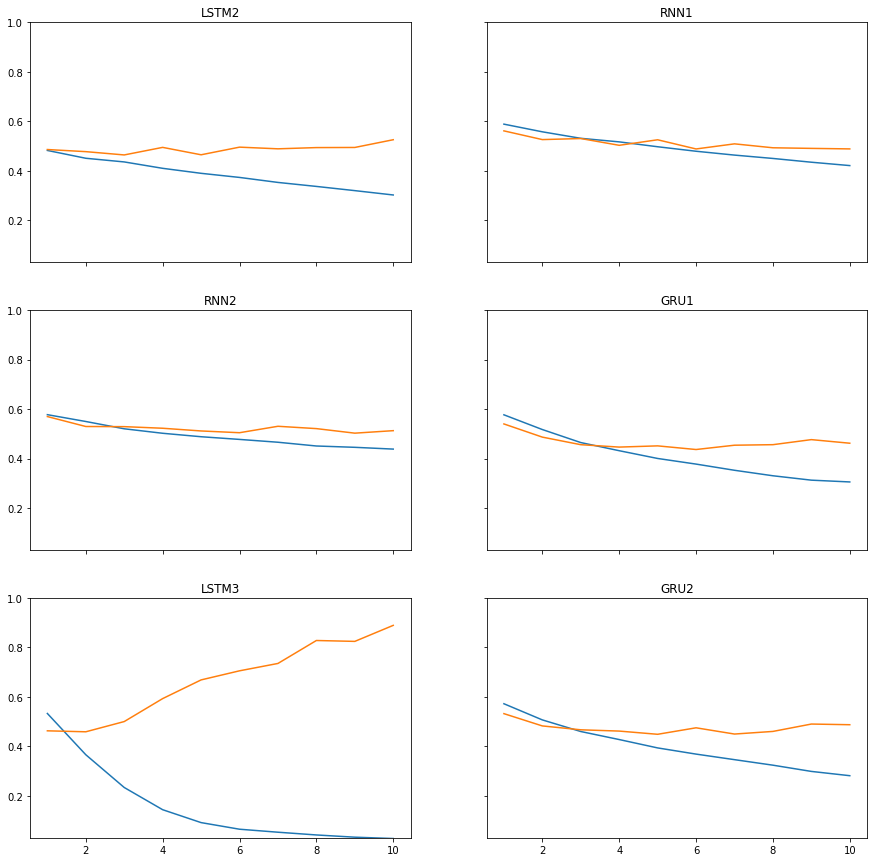

In [157]:
epochRange = np.arange(1,11,1)

f, ((ax2,ax4), (ax1,  ax6), (ax12,  ax10)) = plt.subplots(3,2, sharex='col', sharey='row',figsize=(15, 15))

plt.title('Training Vs Validation loss for all embeddings')


ax2.plot(epochRange,h2.history['loss'])
ax2.plot(epochRange,h2.history['val_loss'])
ax2.set_title('LSTM2')
ax2.set_ylim(0.03, 1)


ax4.plot(epochRange,h3.history['loss'])
ax4.plot(epochRange,h3.history['val_loss'])
ax4.set_title('RNN1')
ax4.set_ylim(0.03, 1)

ax1.plot(epochRange,h4.history['loss'])
ax1.plot(epochRange,h4.history['val_loss'])
ax1.set_title('RNN2')
ax1.set_ylim(0.03, 1)

ax6.plot(epochRange,h5.history['loss'])
ax6.plot(epochRange,h5.history['val_loss'])
ax6.set_title('GRU1')
ax6.set_ylim(0.03, 1)


ax10.plot(epochRange,h6.history['loss'])
ax10.plot(epochRange,h6.history['val_loss'])
ax10.set_title('GRU2')
ax10.set_ylim(0.03, 1)


ax12.plot(epochRange,h7.history['loss'])
ax12.plot(epochRange,h7.history['val_loss'])
ax12.set_title('LSTM3')
ax12.set_ylim(0.03, 1)

plt.show()

## Fill the table for all architectures

<table>
<thead>
<tr>
<th></th>
  <th align="center"><code>        </code></th>
<th align="center"><code>loss</code></th>
<th align="center"><code>        </code></th>
<th align="center"><code>accuracy</code></th>
<th align="center"><code>        </code></th>
<th align="center"><code>val_loss</code></th>
<th align="center"><code>        </code></th>
<th align="center"><code>val_accuracy</code></th>
<th align="center"><code>        </code></th>
</tr>
</thead>
<tbody>
<tr>
<td>LSTM1</td>
 <td align="center"> </td>
<td align="center">0.2567 </td>
<td align="center"> </td>
<td align="center">0.8493</td>
<td align="center"> </td>
  <td align="center">0.4944 </td>
<td align="center"> </td>
<td align="center">0.6653</td>
<td align="center"> </td>
</tr>
<tr>
<td>LSTM2</td>
  <td align="center"> </td>
<td align="center"> 0.3020</td>
<td align="center"> </td>
<td align="center"> 0.7971</td>
<td align="center"></td>
  <td align="center"> 0.5254</td>
<td align="center"> </td>
<td align="center">0.6189</td>
<td align="center"> </td>
</tr>
<tr>
<td>Simple RNN1</td>
  <td align="center"> </td>
<td align="center">0.4209 </td>
<td align="center"> </td>
<td align="center">0.7050</td>
<td align="center"> </td>
 <td align="center"> 0.4883</td>
<td align="center"> </td>
<td align="center">0.6557</td>
<td align="center"> </td>
</tr>
<tr>
<td>Simple RNN 2</td>
  <td align="center"> </td>
<td align="center">0.4419 </td>
<td align="center"> </td>
<td align="center">0.6953 </td>
<td align="center"></td>
 <td align="center"> 0.5127</td>
<td align="center"> </td>
<td align="center">0.6200</td>
<td align="center"> </td>
</tr>
<tr>
<td>GRU1</td>
  <td align="center"> </td>
<td align="center">0.2963 </td>
<td align="center"> </td>
<td align="center"> 0.8095</td>
<td align="center"></td>
 <td align="center">0.4619 </td>
<td align="center"> </td>
<td align="center">0.6829</td>
<td align="center"> </td>
</tr>
<tr>
<td>GRU2</td>
  <td align="center"> </td>
<td align="center"> 0.2712</td>
<td align="center"> </td>
<td align="center"> 0.8332</td>
<td align="center"></td>
 <td align="center"> 0.4874</td>
<td align="center"> </td>
<td align="center">0.6614</td>
<td align="center"> </td>
</tr>
<tr>
<td>LSTM3</td>
  <td align="center"> </td>
<td align="center"> 0.0222</td>
<td align="center"> </td>
<td align="center"> 0.9874</td>
<td align="center"></td>
 <td align="center"> 0.8893</td>
<td align="center"> </td>
<td align="center">0.6569</td>
<td align="center"> </td>
</tr>
<tr>

</tbody>
</table>